In [2]:
import operator
import math
import numpy as np
import pickle
import matplotlib.pyplot as plt
from deap import algorithms, base, creator, tools, gp


In [3]:
# чтение данных
with open('vix.dat', 'rb') as f:
    dfs = pickle.load(f)
    
# считаем датафрейм для калнедарного спреда
df = dfs['base_3rd'] - dfs['base']
df.dropna(how='all', axis=0, inplace=True)

df['VIX_close'] = dfs['base']['Close']

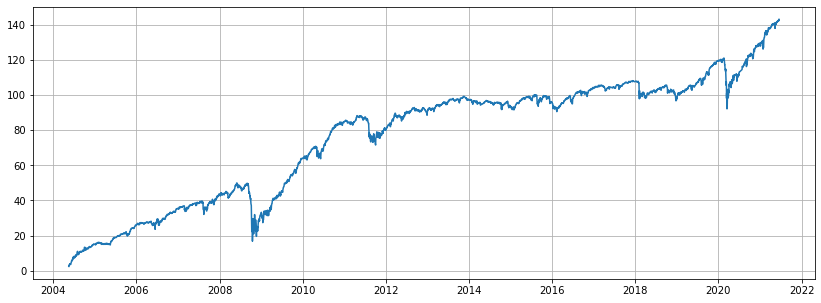

In [5]:
plt.figure(figsize=(14,5))
plt.plot(df['Close_n'])
plt.grid()
plt.show()

In [6]:
def stupid_backtest_3(df, comm_level=0.02/100):
    """В функции реализован простейший бэктест
        но уже с учетом комиссий, комиссии берем за спред
        
        Parameters
        ----------
        df : pd.DataFrame
            датафрейм содержащий ряды signal и Close
        comm_level : float
            уровень комиссий
            
        Returns
        ------
        df : pd.DataFrame
            исходный датафрейм с пнлем с коммиссиями и без
    """
    
    df['pnl'] = (df['Close_n'].diff() * df['signal'].shift()).cumsum()
    df['comm'] = (2 * comm_level * df['VIX_close'] * df['signal'].diff().abs()).cumsum()
    df['pnl_comm'] = df['pnl'] - df['comm']
    
    return df

In [7]:
  
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

def roll10(x):
    return np.roll(x, 10)

def roll100(x):
    return np.roll(x, 100)

pset = gp.PrimitiveSet("MAIN", 1)
pset.addPrimitive(operator.add, 2)
pset.addPrimitive(operator.sub, 2)
pset.addPrimitive(operator.mul, 2)
pset.addPrimitive(operator.neg, 1)
pset.addPrimitive(np.tanh, 1)
pset.addPrimitive(sigmoid, 1)
pset.addPrimitive(roll10, 1)
pset.addPrimitive(roll100, 1)


pset.addEphemeralConstant("rand101", lambda: np.random.randint(-1, 1))
pset.renameArguments(ARG0='x')

creator.create("FitnessMin", base.Fitness, weights=(-1.0,))
creator.create("Individual", gp.PrimitiveTree, fitness=creator.FitnessMin)

toolbox = base.Toolbox()
toolbox.register("expr", gp.genHalfAndHalf, pset=pset, min_=1, max_=2)
toolbox.register("individual", tools.initIterate, creator.Individual, toolbox.expr)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)
toolbox.register("compile", gp.compile, pset=pset)

def estimate_fitness(individual, df):
    # Transform the tree expression in a callable function
    func = toolbox.compile(expr=individual)

    
    df['signal'] = func(df['Close'])
    df.loc[df['signal'] > 1, 'signal'] = 1
    df.loc[df['signal'] < -1, 'signal'] = -1
        
    
    df = stupid_backtest_3(df)
    
    try:
        ret = (df['pnl_comm'] - df['pnl_comm'].shift())
        res = -ret.mean() / ret.std() * np.sqrt(252)
        return res, 

    except:
        return 0,
    

toolbox.register("evaluate", estimate_fitness, df=df)
toolbox.register("select", tools.selTournament, tournsize=3)
toolbox.register("mate", gp.cxOnePoint)
toolbox.register("expr_mut", gp.genFull, min_=0, max_=2)
toolbox.register("mutate", gp.mutUniform, expr=toolbox.expr_mut, pset=pset)

toolbox.decorate("mate", gp.staticLimit(key=operator.attrgetter("height"), max_value=3))
toolbox.decorate("mutate", gp.staticLimit(key=operator.attrgetter("height"), max_value=3))


In [8]:
np.random.seed(318)

pop = toolbox.population(n=300)
hof = tools.HallOfFame(1)

stats_fit = tools.Statistics(lambda ind: ind.fitness.values)
stats_size = tools.Statistics(len)
mstats = tools.MultiStatistics(fitness=stats_fit, size=stats_size)
mstats.register("avg", np.mean)
mstats.register("std", np.std)
mstats.register("min", np.min)
mstats.register("max", np.max)

pop, log = algorithms.eaSimple(pop, toolbox, 0.5, 0.1, 40, stats=mstats,
                               halloffame=hof, verbose=True)


   	      	                            fitness                             	                      size                     
   	      	----------------------------------------------------------------	-----------------------------------------------
gen	nevals	avg       	gen	max    	min      	nevals	std     	avg    	gen	max	min	nevals	std    
0  	300   	-0.0867436	0  	1.02854	-0.989337	300   	0.483113	3.26333	0  	7  	2  	300   	1.34189


C:\Users\edvard\anaconda3\lib\site-packages\pandas\core\arraylike.py:358: RuntimeWarning: overflow encountered in exp
  result = getattr(ufunc, method)(*inputs, **kwargs)


1  	163   	-0.449144 	1  	0.773508	-0.989337	163   	0.419208	3.22   	1  	8  	1  	163   	1.35583
2  	160   	-0.69162  	2  	0.773508	-0.989337	160   	0.344251	3.11   	2  	9  	1  	160   	1.21294
3  	157   	-0.814921 	3  	0.773508	-0.989337	157   	0.297525	2.92333	3  	7  	1  	157   	1.13906
4  	153   	-0.879481 	4  	0.274339	-0.989337	153   	0.220854	2.79667	4  	7  	1  	153   	1.1699 
5  	185   	-0.897484 	5  	0.773508	-0.989337	185   	0.241704	2.68   	5  	7  	1  	185   	1.17938


C:\Users\edvard\anaconda3\lib\site-packages\pandas\core\arraylike.py:358: RuntimeWarning: overflow encountered in exp
  result = getattr(ufunc, method)(*inputs, **kwargs)


6  	155   	-0.919915 	6  	0.773508	-0.989337	155   	0.221339	2.59333	6  	8  	1  	155   	1.20608
7  	160   	-0.923989 	7  	0.773508	-0.989337	160   	0.214888	2.62667	7  	8  	1  	160   	1.18066
8  	173   	-0.923046 	8  	0.333336	-0.989337	173   	0.197273	2.57667	8  	8  	2  	173   	1.12729
9  	177   	-0.950387 	9  	0.773508	-0.989337	177   	0.180747	2.4    	9  	6  	2  	177   	0.912871
10 	162   	-0.937619 	10 	0.773508	-0.989337	162   	0.189686	2.35333	10 	8  	1  	162   	0.949643
11 	184   	-0.938305 	11 	0.333336	-0.989337	184   	0.177267	2.23   	11 	6  	1  	184   	0.785557
12 	179   	-0.933201 	12 	0.773508	-0.989337	179   	0.22504 	2.27   	12 	8  	1  	179   	0.877743
13 	164   	-0.922129 	13 	0.773508	-0.989337	164   	0.236402	2.26   	13 	7  	1  	164   	0.890169
14 	179   	-0.923524 	14 	0.773508	-0.989337	179   	0.236673	2.24667	14 	7  	1  	179   	0.738798


C:\Users\edvard\anaconda3\lib\site-packages\pandas\core\arraylike.py:358: RuntimeWarning: overflow encountered in exp
  result = getattr(ufunc, method)(*inputs, **kwargs)


15 	186   	-0.922918 	15 	0.773508	-0.989337	186   	0.226367	2.20667	15 	7  	1  	186   	0.737533
16 	167   	-0.935671 	16 	0.773508	-0.989337	167   	0.196863	2.20667	16 	7  	1  	167   	0.785677
17 	153   	-0.926743 	17 	0.773508	-0.989337	153   	0.254139	2.17   	17 	6  	1  	153   	0.648922
18 	170   	-0.918798 	18 	0.773508	-0.989337	170   	0.261411	2.24   	18 	7  	1  	170   	0.84601 


C:\Users\edvard\anaconda3\lib\site-packages\pandas\core\arraylike.py:358: RuntimeWarning: overflow encountered in exp
  result = getattr(ufunc, method)(*inputs, **kwargs)


19 	169   	-0.936443 	19 	0.773508	-0.989337	169   	0.212065	2.28667	19 	7  	1  	169   	0.815162
20 	166   	-0.94254  	20 	0.773508	-0.989337	166   	0.21413 	2.24   	20 	6  	1  	166   	0.767507
21 	171   	-0.951274 	21 	0.773508	-0.989337	171   	0.176527	2.19667	21 	7  	1  	171   	0.691367
22 	164   	-0.942545 	22 	0.773508	-0.989337	164   	0.206953	2.22333	22 	7  	1  	164   	0.761658
23 	154   	-0.937042 	23 	0.773508	-0.989337	154   	0.211338	2.22333	23 	7  	1  	154   	0.766021
24 	156   	-0.931843 	24 	0.773508	-0.989337	156   	0.248934	2.15   	24 	7  	1  	156   	0.663953
25 	153   	-0.938011 	25 	1.02854 	-0.989337	153   	0.229061	2.17   	25 	6  	1  	153   	0.674117
26 	160   	-0.930125 	26 	0.773508	-0.989337	160   	0.244757	2.22667	26 	7  	1  	160   	0.805371
27 	199   	-0.942661 	27 	0.773508	-0.989337	199   	0.184412	2.35667	27 	7  	1  	199   	1.04057 
28 	149   	-0.927122 	28 	0.773508	-0.989337	149   	0.214717	2.26333	28 	8  	1  	149   	0.916873


C:\Users\edvard\anaconda3\lib\site-packages\pandas\core\arraylike.py:358: RuntimeWarning: overflow encountered in exp
  result = getattr(ufunc, method)(*inputs, **kwargs)


29 	151   	-0.934102 	29 	0.773508	-0.989337	151   	0.242451	2.17   	29 	7  	1  	151   	0.707884
30 	149   	-0.940813 	30 	0.773508	-0.992677	149   	0.222637	2.15667	30 	7  	1  	149   	0.691946
31 	154   	-0.929628 	31 	0.773508	-0.992677	154   	0.243467	2.14667	31 	7  	1  	154   	0.691729
32 	178   	-0.921889 	32 	0.773508	-0.992677	178   	0.260497	2.21667	32 	7  	1  	178   	0.846398


C:\Users\edvard\anaconda3\lib\site-packages\pandas\core\arraylike.py:358: RuntimeWarning: overflow encountered in exp
  result = getattr(ufunc, method)(*inputs, **kwargs)


33 	167   	-0.940217 	33 	0.773508	-0.992677	167   	0.204452	2.32667	33 	7  	1  	167   	1.16044 


C:\Users\edvard\anaconda3\lib\site-packages\pandas\core\arraylike.py:358: RuntimeWarning: overflow encountered in exp
  result = getattr(ufunc, method)(*inputs, **kwargs)


34 	149   	-0.94528  	34 	0.488135	-0.992677	149   	0.16648 	2.40333	34 	7  	1  	149   	1.20858 
35 	167   	-0.944345 	35 	0.773508	-0.992677	167   	0.194852	2.61   	35 	8  	1  	167   	1.52902 
36 	160   	-0.936331 	36 	0.773508	-0.992677	160   	0.222117	3.05   	36 	7  	1  	160   	1.87461 
37 	162   	-0.936609 	37 	0.364534	-0.992677	162   	0.167243	3.93   	37 	8  	1  	162   	2.14595 
38 	169   	-0.936659 	38 	0.980246	-0.992677	169   	0.202516	4.90667	38 	8  	1  	169   	2.04563 
39 	188   	-0.936397 	39 	0.773508	-0.992677	188   	0.153809	5.53333	39 	8  	1  	188   	1.67199 
40 	169   	-0.938482 	40 	0.773508	-0.992677	169   	0.157333	5.69   	40 	7  	2  	169   	1.61469 


In [9]:
bests = tools.selBest(pop, k=1)

print(bests[0])

sigmoid(sub(add(0, x), sigmoid(x)))


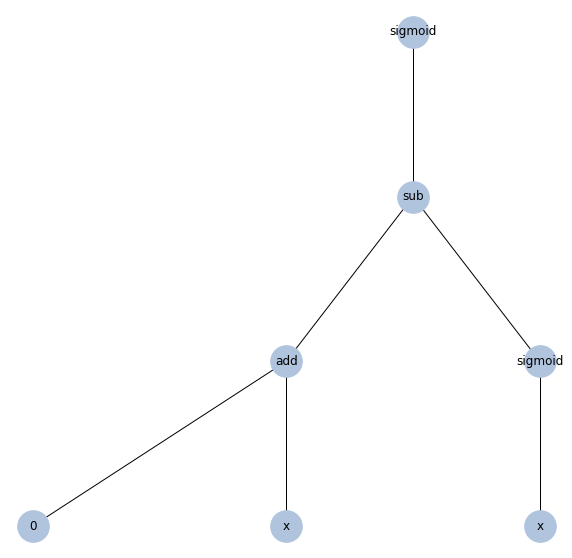

In [14]:
import pygraphviz as pgv
import matplotlib.pyplot as plt
import networkx as nx

nodes, edges, labels = gp.graph(bests[0])
graph = nx.Graph()
graph.add_nodes_from(nodes)
graph.add_edges_from(edges)
#pos = graphviz_layout(graph, prog='dot')
pos = nx.nx_agraph.graphviz_layout(graph, prog="dot")

plt.figure(figsize=(10,10))
nx.draw_networkx_nodes(graph, pos, node_size=1000, node_color="lightsteelblue")
nx.draw_networkx_edges(graph, pos)
nx.draw_networkx_labels(graph, pos, labels)
plt.axis("off")
plt.show()

In [15]:
func = toolbox.compile(expr=bests[0])
df['signal'] = func(df['Close'])

df = stupid_backtest_3(df)

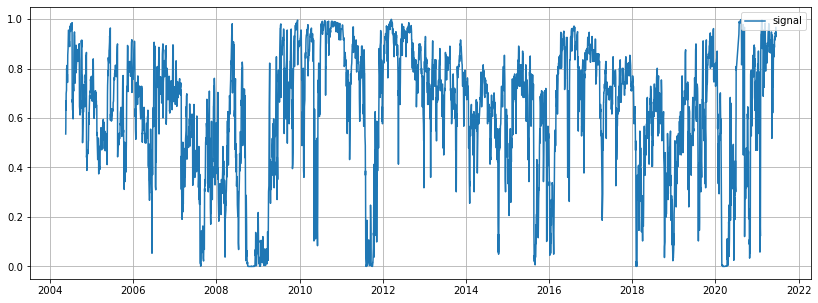

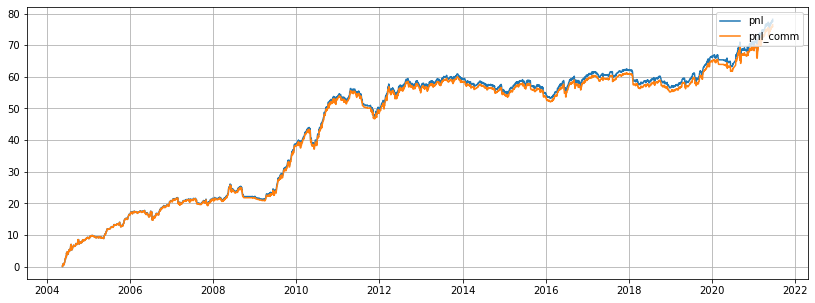

In [16]:
plt.figure(figsize=(14,5))
plt.plot(df['signal'], label='signal')
plt.grid()
plt.legend(loc='upper right')
plt.show()

plt.figure(figsize=(14,5))
plt.plot(df['pnl'], label='pnl')
plt.plot(df['pnl_comm'], label='pnl_comm')
plt.grid()
plt.legend(loc='upper right')
plt.show()